In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os


!pip install scikit_optimize
import skopt
from skopt import gp_minimize, forest_minimize
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_convergence
from skopt.plots import plot_objective, plot_evaluations
from skopt.utils import use_named_args

from sklearn.impute import SimpleImputer
from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score, accuracy_score
!pip install -U mlxtend
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import callbacks, regularizers
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import CuDNNGRU, Dense, BatchNormalization, Dropout, CuDNNLSTM, Flatten
print(tf.__version__)
print(tf.keras.__version__)

Requirement already up-to-date: mlxtend in /usr/local/lib/python3.6/dist-packages (0.17.0)
1.15.0
2.2.4-tf


In [0]:
def load(path):
    from google.colab import drive
    drive.mount('/gdrive')
    data_dir = '/gdrive/My Drive/Studia/INZYNIERKA/StockPricePrediction/data/'
    with open(data_dir + path, 'rb') as handle:
        data = pickle.load(handle)
    return data

In [0]:
def save(path, data):
    from google.colab import drive
    drive.mount('/gdrive')
    data_dir = '/gdrive/My Drive/Studia/INZYNIERKA/StockPricePrediction/data/'
    with open(data_dir + path, 'wb') as handle:
        pickle.dump(data, handle)

In [0]:
model_path = '/gdrive/My Drive/Studia/INZYNIERKA/StockPricePrediction/models/gru.hdf5'
best_model_path = '/gdrive/My Drive/Studia/INZYNIERKA/StockPricePrediction/models/gru_BayOpt.hdf5'

In [15]:
# Load data
train_x, train_y, val_x, val_y, test_x, test_y = load('input/data_lookback_60.pickle')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [0]:
# Hiperparameters and their ranges
dim_learning_rate = Real(low=1e-5, high=2e-2, prior='log-uniform',
                         name='learning_rate')
dim_num_dense_nodes = Integer(low=8, high=128, name='num_dense_nodes')
dim_num_rnn_layers = Integer(low=0, high=2, name='num_rnn_layers')
dim_num_rnn_nodes = Integer(low=8, high=128, name='num_rnn_nodes')
dim_dropout_rate = Real(low=0, high=0.5, name='dropout_rate')

dimensions = [dim_learning_rate,
              dim_num_dense_nodes,
              dim_num_rnn_layers,
              dim_num_rnn_nodes,
              dim_dropout_rate]

default_parameters = [5e-4, 32, 1, 64, 0.3]

best_accuracy = 0.0
best_history = None

In [0]:
def create_model(learning_rate, num_rnn_layers, num_rnn_nodes,
                 num_dense_nodes, dropout_rate, input_shape):
    """
    Hyper-parameters:
    learning_rate:     Learning-rate for the optimizer.
    num_dense_layers:  Number of dense layers.
    num_dense_nodes:   Number of nodes in each dense layer.
    num_rnn_layers:    Number of rnn layers.
    num_rnn_nodes:     Number of nodes in each rnn layer.
    dropout-rate:      Rate of droping in each dropout layer.
    """
    num_dense_layers = 2
    # Start construction of a Keras Sequential model.
    model = Sequential()

    for i in range(num_rnn_layers):
        # Name of the layer. This is not really necessary
        # because Keras should give them unique names.
        name = 'layer_rnn_{0}'.format(i+1)

        # Add the RNN layer to the model.
        # This has two hyper-parameters we want to optimize:
        # The number of nodes and the activation function.
        model.add(CuDNNGRU(num_rnn_nodes,
                           return_sequences=True,
                           kernel_regularizer=regularizers.l2(),
                           activity_regularizer=regularizers.l2(),
                           input_shape=input_shape,
                           name=name))
        model.add(Dropout(dropout_rate))
        
    model.add(CuDNNGRU(num_rnn_nodes,
                       return_sequences=False,
                       kernel_regularizer=regularizers.l2(),
                       activity_regularizer=regularizers.l2(),
                       input_shape=input_shape,
                       name='layer_rnn_'+str(num_rnn_layers+1)))

    model.add(Dropout(dropout_rate))

    # Add fully-connected / dense layers.
    # The number of layers is a hyper-parameter we want to optimize.
    for i in range(num_dense_layers):
        # Name of the layer. This is not really necessary
        # because Keras should give them unique names.
        name = 'layer_dense_{0}'.format(i+1)

        # Add the dense / fully-connected layer to the model.
        # This has two hyper-parameters we want to optimize:
        # The number of nodes and the activation function.
        model.add(Dense(num_dense_nodes,
                        activation='relu',
                        kernel_regularizer=regularizers.l2(),
                        name=name))
        model.add(Dropout(dropout_rate))

    # Last fully-connected / dense layer with softmax-activation
    # for use in classification.
    model.add(Dense(1, activation='sigmoid'))
    
    # Use the Adam method for training the network.
    # We want to find the best learning-rate for the Adam method.
    optimizer = keras.optimizers.Adam(lr=learning_rate)
    
    # In Keras we need to compile the model so it can be trained.
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [0]:
@use_named_args(dimensions=dimensions)
def fitness(learning_rate,
            num_dense_nodes,
            num_rnn_layers, num_rnn_nodes,
            dropout_rate):
    """
    Hyper-parameters:
    learning_rate:     Learning-rate for the optimizer.
    num_dense_nodes:   Number of nodes in each dense layer.
    num_rnn_layers:    Number of rnn layers.
    num_rnn_nodes:     Number of nodes in each rnn layer.
    dropout-rate:      Rate of droping in each dropout layer.
    """

    global i
    print('index', i)
    i += 1

    # Print the hyper-parameters.
    print('learning rate: {0:.1e}'.format(learning_rate))
    print('num_dense_nodes:', num_dense_nodes)
    print('num_rnn_layers:', num_rnn_layers)
    print('num_rnn_nodes:', num_rnn_nodes)
    print('dropout_rate', dropout_rate)
    
    verbose = 0

    es = callbacks.EarlyStopping(monitor='val_loss', verbose=verbose, patience=20, min_delta=0.0001) 
    mc = callbacks.ModelCheckpoint(model_path, monitor='val_acc', verbose=verbose, save_best_only=True)

    # Create the neural network with these hyper-parameters.
    model = create_model(learning_rate=learning_rate,
                         num_dense_nodes=num_dense_nodes,
                         num_rnn_layers=num_rnn_layers,
                         num_rnn_nodes=num_rnn_nodes,
                         dropout_rate=dropout_rate,
                         input_shape=(train_x.shape[-2:]))
    
    # print(model.summary())
   
    # Use Keras to train the model.
    with tf.device('/gpu:0'):  
        history = model.fit(train_x, train_y, epochs=150, verbose=verbose, validation_data=(val_x, val_y), batch_size=32, callbacks=[es, mc],
                            validation_steps=100)

    # Get the classification accuracy on the validation-set
    # after the last training-epoch.
    model = load_model(model_path)
    predictions = model.predict(test_x)
    predictions = (predictions > 0.5)
    accuracy = accuracy_score(test_y, predictions)
    print('Highest validation accuracy: {0:.2%}'.format(max(history.history['val_acc'])))

    # Print the classification accuracy.
    print("Accuracy: {0:.2%}".format(accuracy))
    print()
    print()

    # Save the model if it improves on the best-found performance.
    # We use the global keyword so we update the variable outside
    # of this function.
    global best_accuracy
    global best_history

    # If the classification accuracy of the saved model is improved ...
    if accuracy > best_accuracy:
        # Save the new model to harddisk.
        model.save(best_model_path)
        
        # Update the classification accuracy.
        best_accuracy = accuracy
        best_history = history

    # Delete the Keras model with these hyper-parameters from memory.
    del model
    
    # Clear the Keras session, otherwise it will keep adding new
    # models to the same TensorFlow graph each time we create
    # a model with a different set of hyper-parameters.
    tf.keras.backend.clear_session()
    tf.reset_default_graph()
    
    # NOTE: Scikit-optimize does minimization so it tries to
    # find a set of hyper-parameters with the LOWEST fitness-value.
    # Because we are interested in the HIGHEST classification
    # accuracy, we need to negate this number so it can be minimized.
    return -accuracy

In [19]:
i = 0
fitness(x=default_parameters)

index 0
learning rate: 5.0e-04
num_dense_nodes: 32
num_rnn_layers: 1
num_rnn_nodes: 64
dropout_rate 0.3
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Highest validation accuracy: 68.02%
Accuracy: 59.30%




-0.5930232558139535

In [23]:
i = 0
search_result = gp_minimize(func=fitness,
                            dimensions=dimensions,
                            acq_func='PI', # Expected Improvement.
                            n_calls=50,
                            x0=default_parameters)

index 0
learning rate: 5.0e-04
num_dense_nodes: 32
num_rnn_layers: 1
num_rnn_nodes: 64
dropout_rate 0.3
Highest validation accuracy: 66.86%
Accuracy: 59.88%


index 1
learning rate: 1.5e-04
num_dense_nodes: 109
num_rnn_layers: 1
num_rnn_nodes: 104
dropout_rate 0.37559306198914616
Highest validation accuracy: 87.79%
Accuracy: 77.91%


index 2
learning rate: 3.4e-04
num_dense_nodes: 44
num_rnn_layers: 1
num_rnn_nodes: 50
dropout_rate 0.34485195507884814
Highest validation accuracy: 67.44%
Accuracy: 59.30%


index 3
learning rate: 7.2e-05
num_dense_nodes: 54
num_rnn_layers: 1
num_rnn_nodes: 10
dropout_rate 0.15352531464763972
Highest validation accuracy: 54.65%
Accuracy: 49.42%


index 4
learning rate: 1.2e-04
num_dense_nodes: 41
num_rnn_layers: 1
num_rnn_nodes: 67
dropout_rate 0.05319101408801076
Highest validation accuracy: 86.63%
Accuracy: 70.35%


index 5
learning rate: 1.2e-03
num_dense_nodes: 92
num_rnn_layers: 1
num_rnn_nodes: 113
dropout_rate 0.4558255924294112
Highest validation 

In [24]:
dim_names = ['learning_rate', 'num_dense_nodes', 'num_rnn_layers', 'num_rnn_nodes', 'dropout_rate']
# best params
best_params = search_result.x
for k, v in zip(dim_names, best_params):
    print(k, ' -> ', v)

# highest accuracy value on test set
acc = round(-1 *search_result.fun, 2)
print('Best accuracy -> ', acc)

learning_rate  ->  0.00015295857183217706
num_dense_nodes  ->  109
num_rnn_layers  ->  1
num_rnn_nodes  ->  104
dropout_rate  ->  0.37559306198914616
Best accuracy ->  0.78


<Figure size 1440x1440 with 0 Axes>

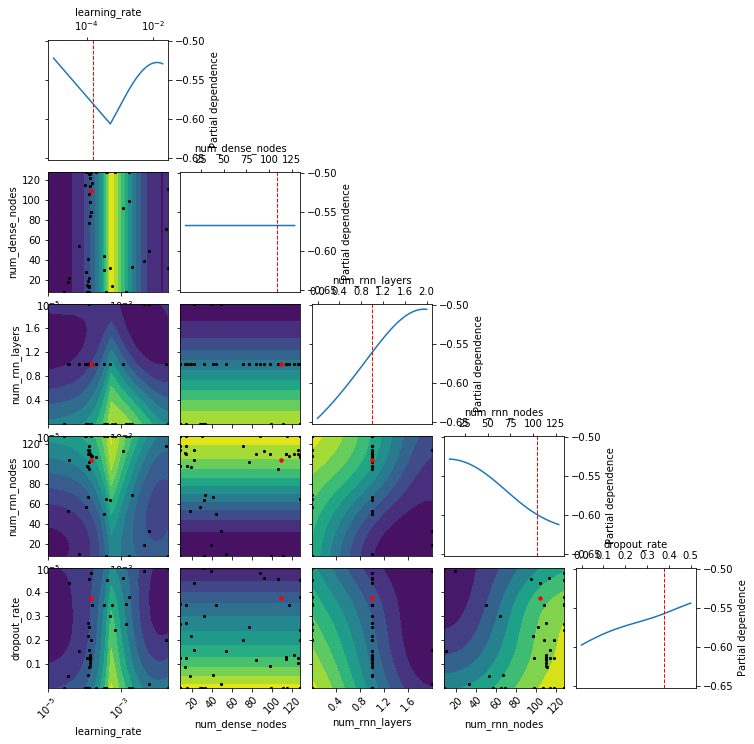

In [37]:
plt.rcParams.update({'font.size': 10})
fig = plt.figure(figsize=(20, 20))
_ = plot_objective(result=search_result, dimensions=dim_names)

<Figure size 1440x1440 with 0 Axes>

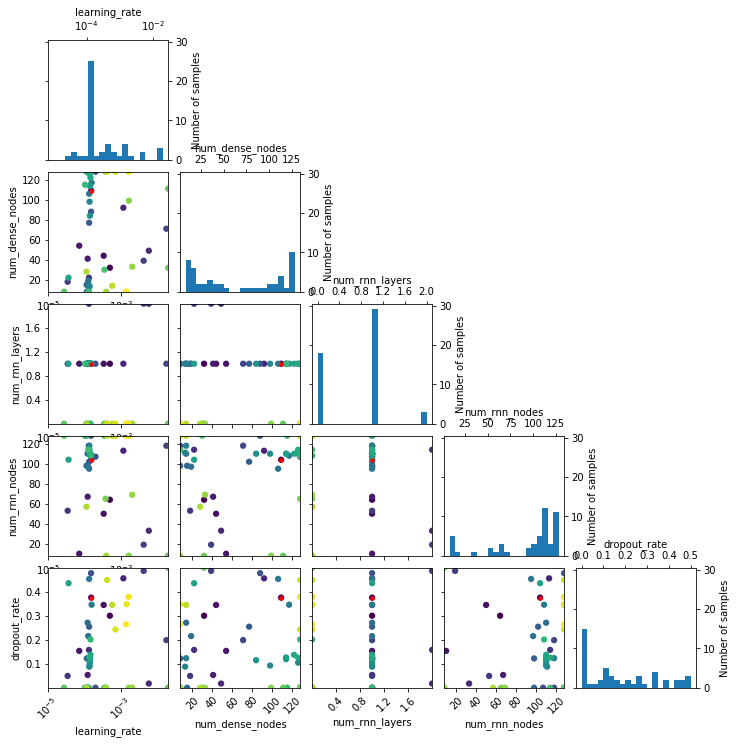

In [38]:
fig1 = plt.figure(figsize=(20, 20))
_ = plot_evaluations(search_result, dimensions=dim_names)

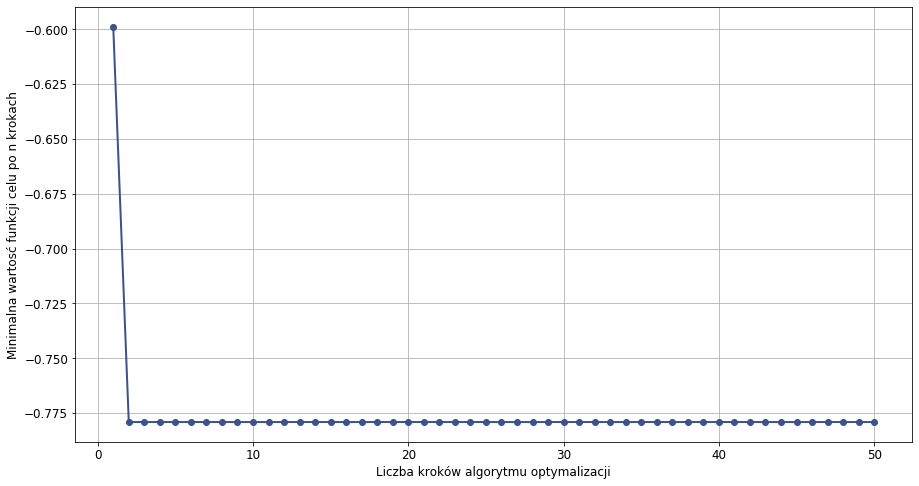

In [27]:
plt.rcParams.update({'font.size': 12})
fig2 = plt.figure(figsize=(15, 8))
_ = plot_convergence(search_result)
_ = plt.ylabel('Minimalna wartosć funkcji celu po n krokach')
_ = plt.xlabel('Liczba kroków algorytmu optymalizacji')
_ = plt.title('')

In [28]:
model = load_model(best_model_path)
print(model.summary())
predictions = model.predict(test_x)
predictions = (predictions > 0.5)
predictions = [int(pred) for pred in predictions]
prec = precision_score(test_y, predictions)
rec = recall_score(test_y, predictions)
acc = accuracy_score(test_y, predictions)

print(f"Accuracy: {round(acc * 100,2)}%")
print(f"precision: {round(prec * 100,2)}%")
print(f"recall: {round(rec * 100,2)}%")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_rnn_1 (CuDNNGRU)       (None, 60, 104)           43992     
_________________________________________________________________
dropout (Dropout)            (None, 60, 104)           0         
_________________________________________________________________
layer_rnn_2 (CuDNNGRU)       (None, 104)               65520     
_________________________________________________________________
dropout_1 (Dropout)          (None, 104)               0         
_________________________________________________________________
layer_dense_1 (Dense)        (None, 109)               11445     
_________________________________________________________________
dropout_2 (Dropout)          (None, 109)               0         
_________________________________________________________________
layer_dense_2 (Dense)        (None, 109)               1

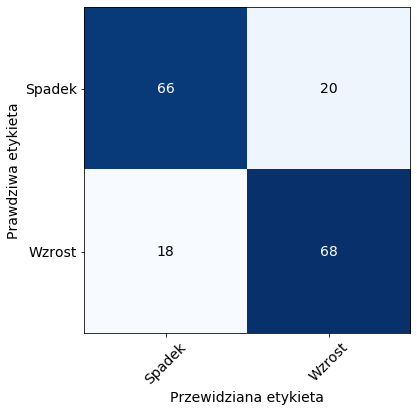

In [29]:
plt.rcParams.update({'font.size': 14})
cm = confusion_matrix(y_target=test_y, 
                    y_predicted=predictions)

fig, ax = plot_confusion_matrix(conf_mat=cm,
                                class_names=['Spadek', 'Wzrost'],
                                figsize=(6,6))
_ = plt.ylabel('Prawdziwa etykieta')
_ = plt.xlabel('Przewidziana etykieta')

In [30]:
model.evaluate(test_x, test_y, steps=10)

10/10 [==============================] - 0s 14ms/step - loss: 0.7945 - acc: 0.7791


[0.7945116758346558, 0.7790698]

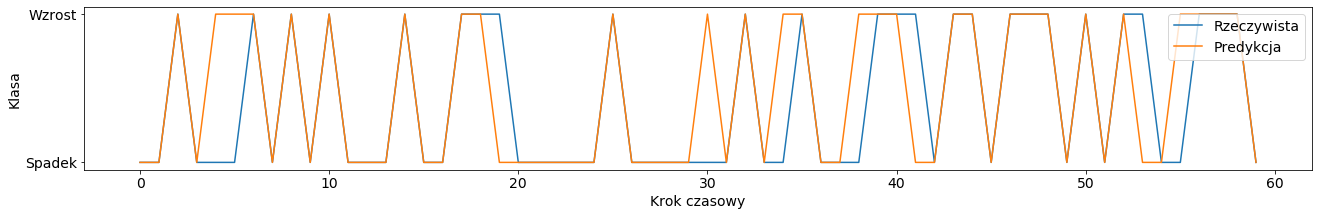

In [33]:
def plot_predictions(length=60):
    fig = plt.figure(figsize=(22,3))
    plt.plot(test_y[:length])
    plt.plot(np.array(predictions)[:length])
    plt.legend(['Rzeczywista', 'Predykcja'], loc=1)
    plt.xlabel('Krok czasowy')
    plt.ylabel('Klasa')
    plt.yticks([0, 1], ['Spadek', 'Wzrost'])

plot_predictions()

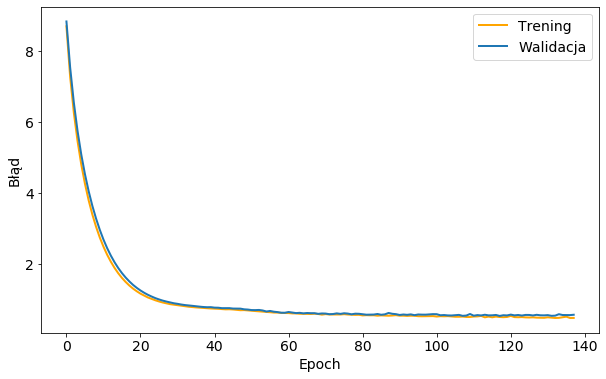

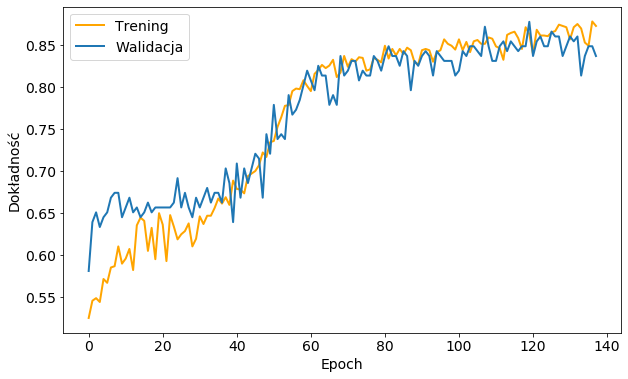

In [34]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    plt.figure(figsize=(10, 6))
    plt.xlabel('Epoch')
    plt.ylabel('Błąd')
    plt.plot(hist['epoch'], hist['loss'], linewidth=2, color='orange',
            label='Trening')
    plt.plot(hist['epoch'], hist['val_loss'], linewidth=2,
            label = 'Walidacja')
    plt.legend()

    plt.figure(figsize=(10, 6))
    plt.xlabel('Epoch')
    plt.ylabel('Dokładność')
    plt.plot(hist['epoch'], hist['acc'], linewidth=2, color='orange',
            label='Trening')
    plt.plot(hist['epoch'], hist['val_acc'], linewidth=2,
            label = 'Walidacja')
    plt.legend()

plot_history(best_history)

In [35]:
print(len(predictions))
save('predictions/gru.pickle', predictions)

172
Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
